In [1]:
import numpy as np
import pandas as pd
from keras import models, layers

import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
import json
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

In [2]:
training_data_path = '../data/datasets/training_data_noisy_small_track_symetric_delayed_deviation.csv'
df = pd.read_csv(training_data_path)
print(f'{df.shape=}')
df.sample(5)

df.shape=(23760, 19)


,steering_angle,waypoint1_lat,waypoint1_lon,waypoint2_lat,waypoint2_lon,waypoint3_lat,waypoint3_lon,waypoint4_lat,waypoint4_lon,waypoint5_lat,waypoint5_lon,waypoint6_lat,waypoint6_lon,waypoint7_lat,waypoint7_lon,waypoint8_lat,waypoint8_lon,waypoint9_lat,waypoint9_lon
14137,-0.200000,4.290810,-0.893769,7.754358,-2.860454,11.731762,-1.383203,14.974001,-1.925872,17.921673,-1.620842,20.681070,0.513478,20.658023,3.990018,20.021485,7.410892,21.384522,11.157661
3963,0.200000,3.016548,-0.489197,6.116520,-1.831112,8.523489,-4.219834,10.483053,-6.996920,12.374258,-9.820341,13.962256,-12.826433,15.561605,-15.826717,17.160938,-18.826976,18.760315,-21.827272
15783,0.200000,3.188458,0.354444,6.562893,-0.268400,9.354630,-2.989334,10.719047,-5.505717,13.047912,-8.797045,14.458400,-11.269198,17.112651,-14.430245,18.870258,-17.175788,19.409737,-18.979139
18735,-0.365609,3.897949,0.998416,8.625849,0.910474,12.064897,0.298380,14.239747,1.166753,15.476114,2.702456,15.887489,5.946264,15.856696,8.816229,15.335025,12.213601,16.514362,16.148116
15762,0.200000,2.499079,0.619786,5.878466,-0.360592,9.644509,-2.098110,11.211411,-3.971147,12.752706,-7.223862,15.303197,-10.136884,15.508027,-13.033552,19.210482,-15.445955,19.720763,-18.964766


In [3]:
X = df.drop(columns=['steering_angle'])
y = df['steering_angle']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((19008, 18), (4752, 18), (19008,), (4752,))

In [4]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42, n_jobs=-1)
rf_model.fit(X_train, y_train)

RandomForestRegressor(n_jobs=-1, random_state=42)

In [5]:
y_pred = rf_model.predict(X_test)

mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

metrics_df = pd.DataFrame({
    "Metric": ["Mean Squared Error (MSE)", "Mean Absolute Error (MAE)", "R-squared (R2)"],
    "Value": [mse, mae, r2]
})

metrics_df

,Metric,Value
0,Mean Squared Error (MSE),0.005195
1,Mean Absolute Error (MAE),0.046144
2,R-squared (R2),0.903982


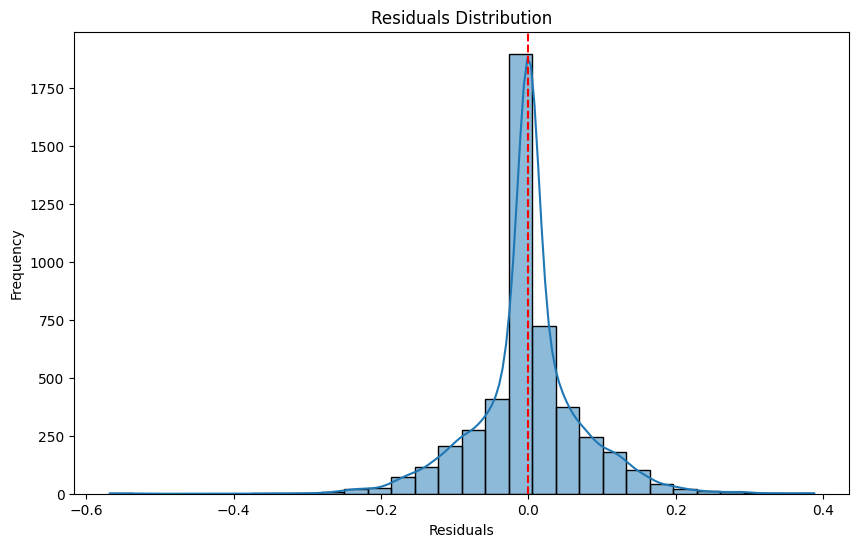

In [6]:
residuals = y_test - y_pred.flatten()
plt.figure(figsize=(10, 6))
sns.histplot(residuals, kde=True, bins=30)
plt.axvline(0, color='red', linestyle='--')
plt.xlabel('Residuals')
plt.ylabel('Frequency')
plt.title('Residuals Distribution')
plt.show()

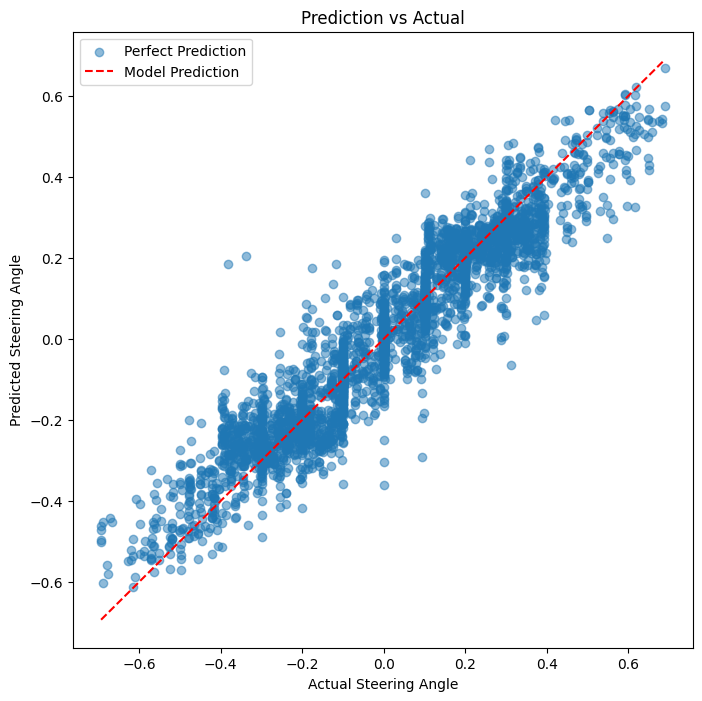

In [7]:
plt.figure(figsize=(8, 8))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.xlabel('Actual Steering Angle')
plt.ylabel('Predicted Steering Angle')
plt.title('Prediction vs Actual')
plt.legend(['Perfect Prediction', 'Model Prediction'])
plt.show()

In [8]:
import joblib

name = 'random_forest_regressor'
model_path = f'../models/{name}.gz'

joblib.dump(rf_model, model_path)

# Save the model parameters
model_params = {
    'n_estimators': rf_model.n_estimators,
    'max_depth': rf_model.max_depth,
    'min_samples_split': rf_model.min_samples_split,
    'min_samples_leaf': rf_model.min_samples_leaf,
    'random_state': rf_model.random_state
}

In [9]:
timestamp = pd.Timestamp.now().isoformat()
metadata = {
    "model_name": name,
    "model_path": f"../models/{name}.json",
    "training_data_path": training_data_path,
    "timestamp": timestamp,
    "input_shape": list(X_train.shape[1:]),
    "output_shape": [1],
    "optimizer": {
        "type": "Adam",
        "learning_rate": 0.001
    },
    "loss_function": "mse",
    "metrics": ["mae"],
    "training": model_params,
    "evaluation": {
        "mse": mse,
        "mae": mae,
        "r2": r2
    }
}

try:
    with open("metadata.jsonl", "r+") as f:
        lines = f.readlines()
        entry = json.dumps(metadata) + "\n"
        if entry not in lines:
            f.write(entry)
except FileNotFoundError:
    with open("metadata.jsonl", "w") as f:
        f.write(json.dumps(metadata) + "\n")

In [10]:
with open("metadata.jsonl", "r") as f:
    lines = f.readlines()

print(json.dumps(json.loads(lines[-1]), indent=4))

{
    "model_name": "random_forest_regressor",
    "model_path": "../models/random_forest_regressor.json",
    "training_data_path": "../data/datasets/training_data_noisy_small_track_symetric_delayed_deviation.csv",
    "timestamp": "2025-06-04T19:00:40.253539",
    "input_shape": [
        18
    ],
    "output_shape": [
        1
    ],
    "optimizer": {
        "type": "Adam",
        "learning_rate": 0.001
    },
    "loss_function": "mse",
    "metrics": [
        "mae"
    ],
    "training": {
        "n_estimators": 100,
        "max_depth": null,
        "min_samples_split": 2,
        "min_samples_leaf": 1,
        "random_state": 42
    },
    "evaluation": {
        "mse": 0.005195030294965646,
        "mae": 0.046144142258543595,
        "r2": 0.9039818917733613
    }
}
